In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
from psiam_tied_dv_map_utils import down_RTs_fit_TRUNC_fn, up_RTs_fit_TRUNC_fn
from psiam_tied_no_dv_map_utils import cum_A_t_fn
import random


In [38]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [39]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
df_1 = df_1[ df_1['timed_fix'] > df_1['intended_fix'] ]

# remove data points from df_1 for no second peak

(0.0, 1.0)

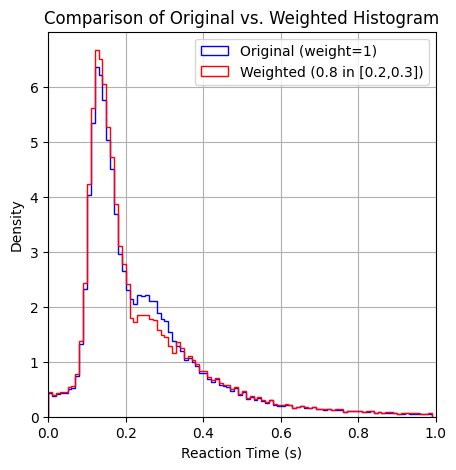

In [40]:
bins = np.arange(0, 1, 0.01)
rt = df_1['timed_fix'] - df_1['intended_fix']

# Create a weight array initialized to 1s
weights = np.ones_like(rt)

# Identify the bump region between 0.20 and 0.30 s, and down-weight by 0.9
bump_mask = (rt >= 0.21) & (rt <= 0.33)
weights[bump_mask] = 0.8
plt.figure(figsize=(5,5))
# Plot the original histogram
plt.hist(rt, bins=bins, color='b', label='Original (weight=1)',
         density=True, histtype='step')

# Plot the weighted histogram
plt.hist(rt, bins=bins, color='r', label='Weighted (0.8 in [0.2,0.3])',
         weights=weights, density=True, histtype='step')

plt.xlabel("Reaction Time (s)")
plt.ylabel("Density")
plt.title("Comparison of Original vs. Weighted Histogram")
plt.legend()
plt.grid(True)
plt.xlim(0,1)
# xticks = np.arange(0,0.4,0.01)
# plt.xticks(xticks);


In [7]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [8]:
vp_sample = vp.sample(int(1e6))[0]

In [9]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor
# t_A_aff = 0.05 # NOTE: TEMP, to test if negative afferent delay is causing VBMC to not converge

In [10]:
t_A_aff

-0.2265445245626065

# VBMC

## loglike fn

In [11]:
T_trunc_aborts = 0.3

In [12]:
def compute_likelihood_and_weight(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    """Compute the *unweighted* likelihood for this row, plus its weight w_i."""
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    rt = timed_fix
    t_stim = intended_fix

    K_max = 10

    trunc_factor = 1 - cum_A_t_fn(T_trunc_aborts - t_A_aff, V_A, theta_A)

    # -- Call your up/down RT fit functions (unweighted) --
    if rt < t_stim:
        likelihood = rho_A_t_fn(rt - t_A_aff - t_motor, V_A, theta_A)
    else:
        if choice == 3:
            likelihood = up_RTs_fit_fn(
                [rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,
                theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max
            )[0]
        elif choice == 2:
            likelihood = down_RTs_fit_fn(
                [rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,
                theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max
            )[0]
        else:
            # If not choice 2 or 3, return a "null" result
            return 1e-50, 1.0

    # Clip very small likelihoods
    if likelihood <= 0:
        likelihood = 1e-50

    likelihood /= trunc_factor
    # -- Compute weight w_i for bump region --
    w = 0.8 if 0.21 <= (rt - t_stim) <= 0.33 else 1.0
    
    return likelihood, w


def psiam_tied_loglike_fn(params):
    """Compute total log-likelihood with down-weighting in [0.21, 0.33], 
       then re-normalization so total mass stays the same.
    """
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    # 1) First pass: collect (likelihood, weight) for each data point
    results = Parallel(n_jobs=30)(
        delayed(compute_likelihood_and_weight)(
            row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L
        )
        for _, row in df_1.iterrows()
        if (row['timed_fix'] > row['intended_fix']) and (row['response_poke'] in [2, 3])
    )

    # Separate into arrays
    L_array = np.array([r[0] for r in results])  # unweighted likelihoods
    W_array = np.array([r[1] for r in results])  # weights

    # 2) Compute total mass before and after weighting
    M_orig = np.sum(L_array)             # sum of unweighted likelihoods
    M_weighted = np.sum(L_array * W_array)  # sum after weighting

    # 3) Normalization factor Z so that sum of final likelihood == sum of original
    #    i.e., M_weighted / Z = M_orig  =>  Z = M_weighted / M_orig
    if M_orig < 1e-50:  
        # Edge case: if M_orig=0 or extremely small, return a large negative loglike
        return -1e10

    Z = M_weighted / M_orig

    # 4) Final likelihood for each data point = (w_i * L_i) / Z
    #    Then sum of log-likelihood
    L_final = (W_array * L_array) / Z
    # Avoid log(0)
    L_final = np.clip(L_final, 1e-50, None)
    loglike = np.sum(np.log(L_final))

    return loglike


## Bounds

In [13]:
rate_lambda_bounds = [0.01, 0.2]
theta_E_bounds = [30, 60]
T_0_bounds = [0.1*(1e-3), 1*(1e-3)]


t_E_aff_bounds = [0.001, 0.1]
Z_E_bounds = [-10, 10]
L_bounds = [0.1, 1.99]

# ---
rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_E_aff_plausible_bounds = [0.01, 0.05]
Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.5, 1.5]

## prior

In [14]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [15]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [58]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        4105.00      6143.95          inf        2        inf     start warm-up
     1         15       17076.73      1717.89     15897.94        2        inf     
     2         20       18499.97     10732.77     74298.71        2   1.05e+06     
     3         25       15155.67      1834.91      7687.83        2   1.22e+05     
     4         30       13359.60      3597.60      2442.44        2   5.12e+04     
     5         35       12588.17      1658.69      5574.11        2    8.4e+04     
     6         40       13306.02      3129.48      3392.08        2    5.9e+04     
     7         45       12857.94      2003.7

In [15]:
vbmc.save('include_aborts_reduced_wt_like.pkl')

In [16]:
with open('include_aborts_reduced_wt_like.pkl', 'rb') as f:
    vp = pickle.load(f)

In [17]:
vp = vp.vp

In [43]:
vp.stats['elbo']

12967.388231969997

## corner plots

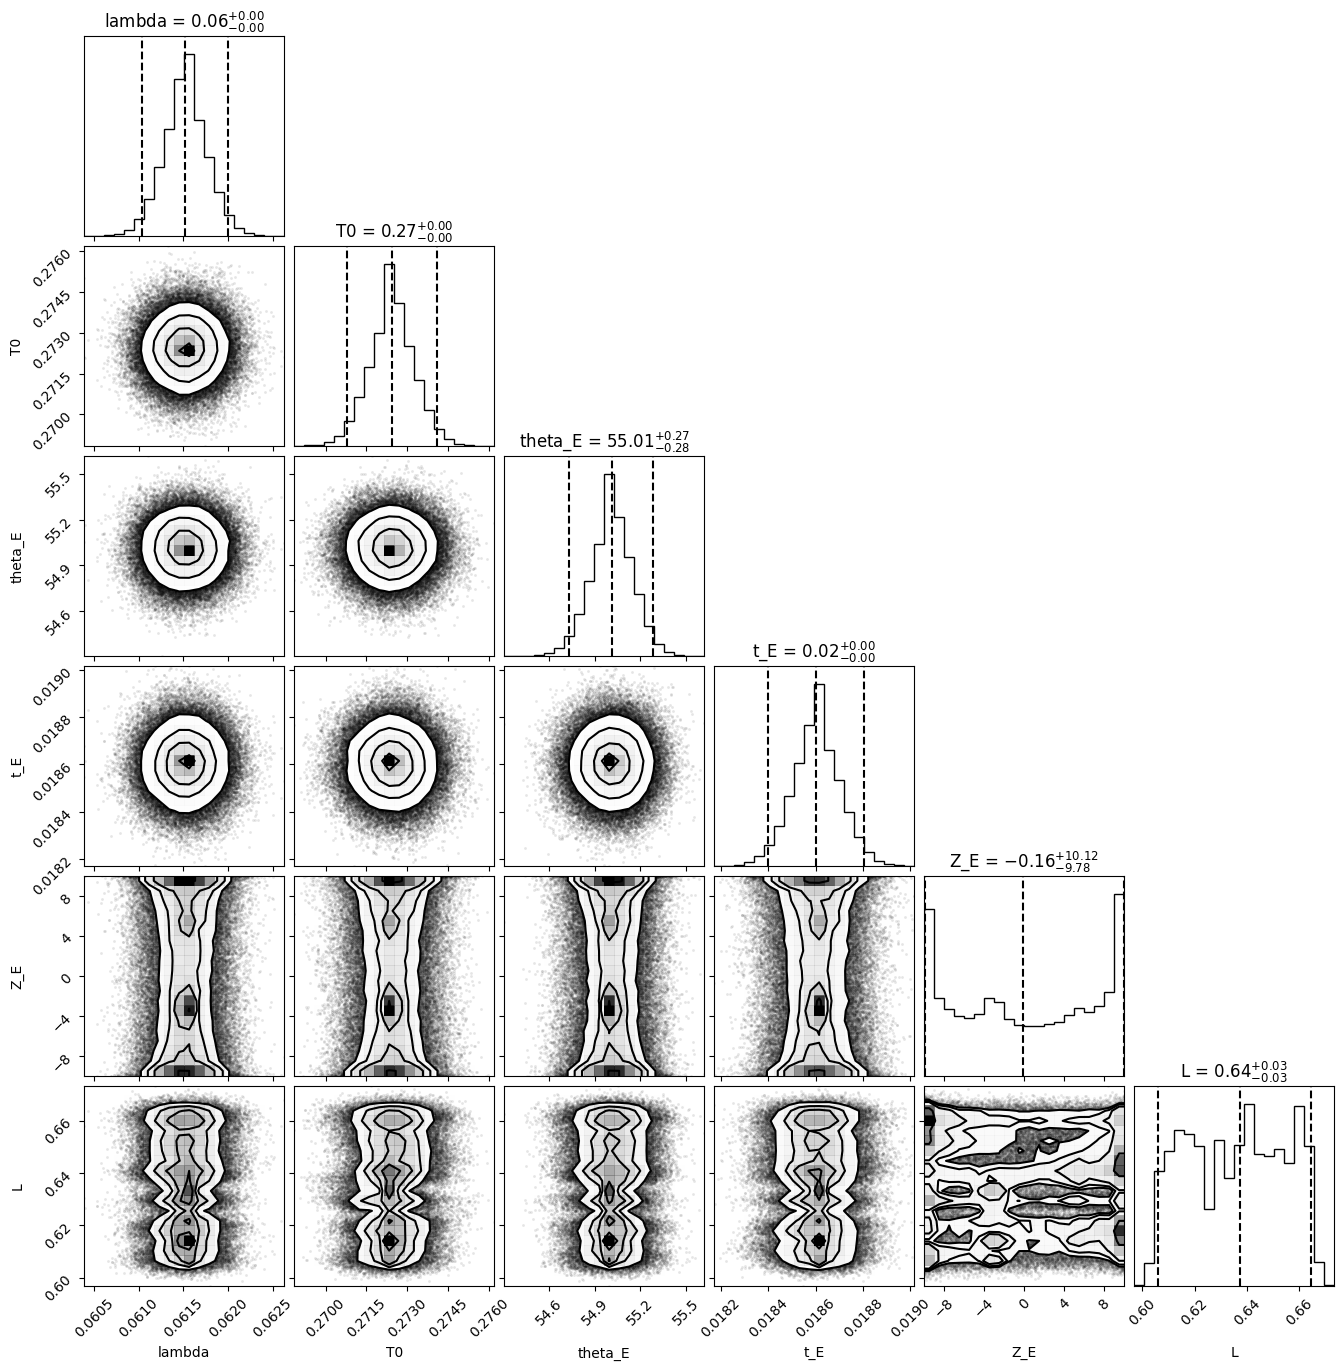

In [18]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [0, 100], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# diagnose

## simulate data

In [19]:
lambda_mean = np.mean(vp_samples[:,0])
T0_mean = np.mean(vp_samples[:,1]) / 1e3
theta_E_mean = np.mean(vp_samples[:,2])

t_E_aff_mean = np.mean(vp_samples[:,3])
Z_E_mean = np.mean(vp_samples[:,4])
L_mean = np.mean(vp_samples[:,5])

In [33]:
dt = 1e-3
N_sim = int(1e6)
N_print  = N_sim + 1
# sample intended_fix of N_sim from df_1
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)

# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
#                                 t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

In iter_num: 0, ABL: 20, ILD: -4.0, t_stim: 0.573165921476377


# diagnostics

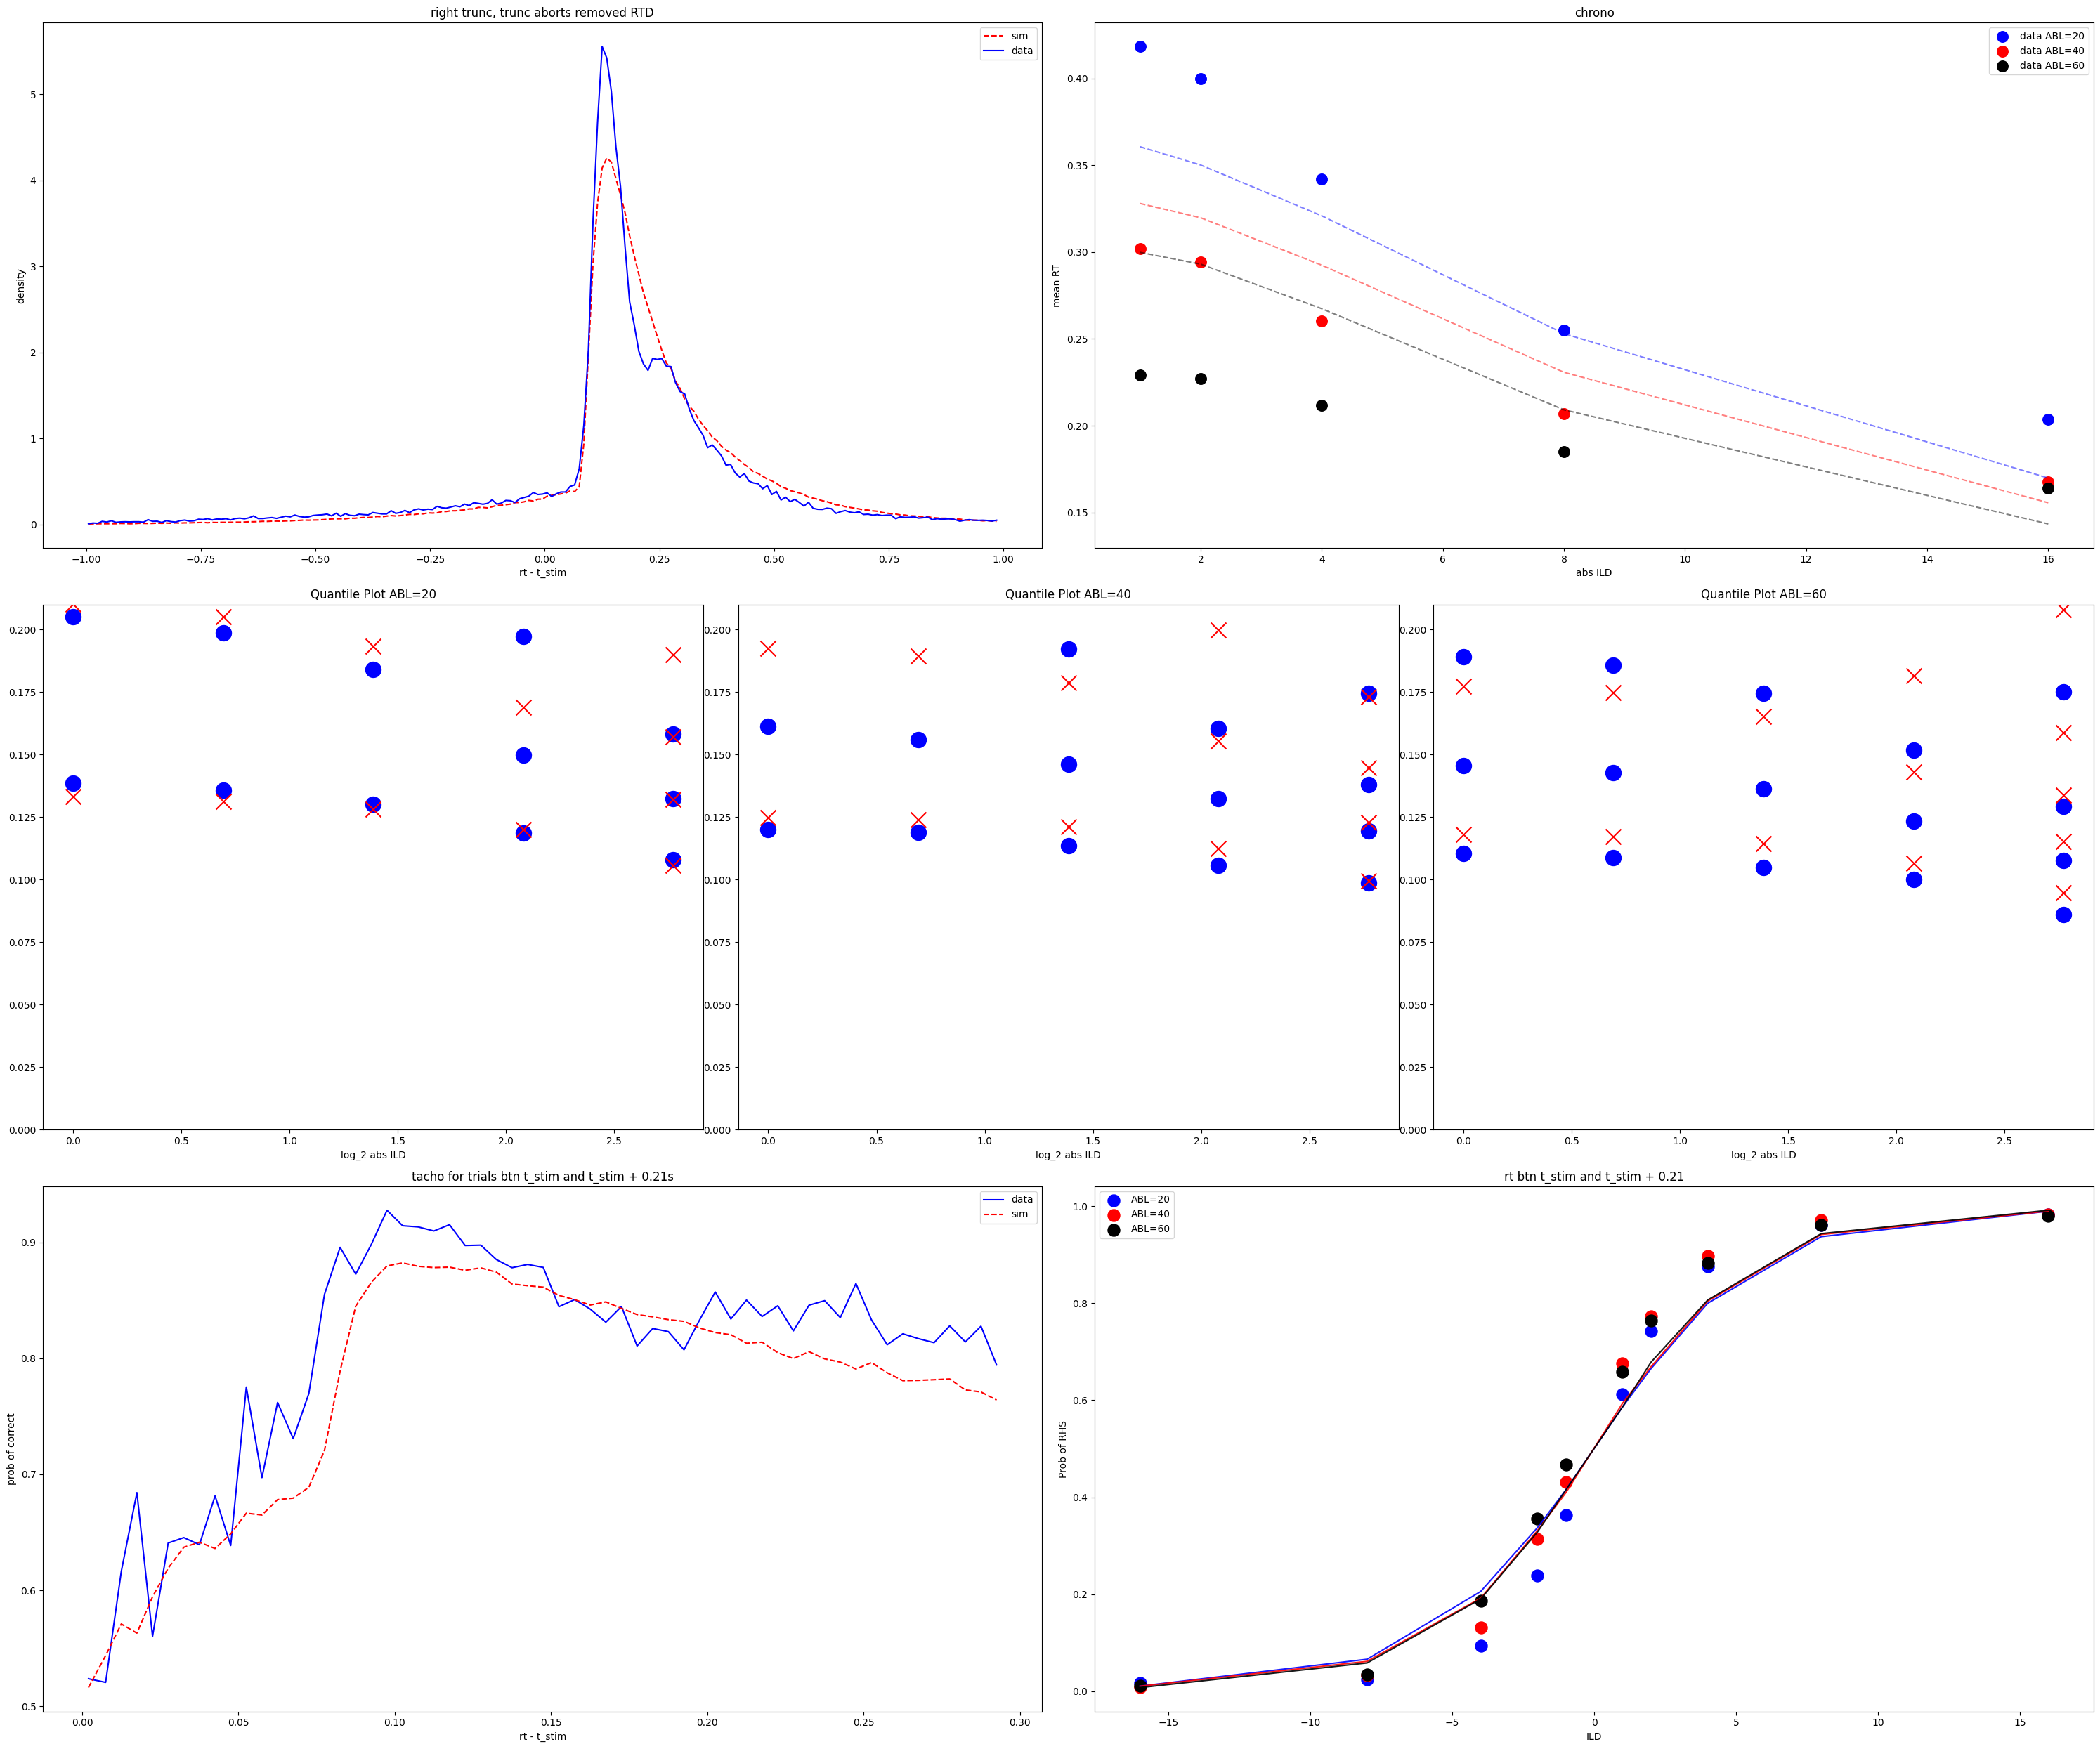

In [42]:
from diagnostics_class import Diagnostics
T_trunc_left_aborts = 0.3

sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
sim_results_2 = sim_results_1 # only trunc aborts removed

df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
df_led_off_trunc_1 =  df_led_off_trunc # only trunc aborts removed

sim_diagnose_obj = Diagnostics(pd.DataFrame(sim_results_2))
data_diagnose_obj = Diagnostics(df_led_off_trunc_1)

fig = plt.figure(figsize=(30, 25))
gs = fig.add_gridspec(3, 2)

### PLOT 1
ax1 = fig.add_subplot(gs[0, 0])
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='sim', ls='--', color='r')
x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='data', color='b')
ax1.set_title('right trunc, trunc aborts removed RTD')
ax1.set_xlabel('rt - t_stim')
ax1.set_ylabel('density')
ax1.legend()

data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']])
for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

sim_results_pd_valid = pd.DataFrame(sim_results_2)
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

### PLOT 2
ax2 = fig.add_subplot(gs[0, 1])
ABL_colors = {20: 'b', 40: 'r', 60: 'k'}
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax2.plot(x, sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax2.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
ax2.legend()
ax2.set_xlabel('abs ILD')
ax2.set_ylabel('mean RT')
ax2.set_title('chrono')

### PLOT 3
gs_row1 = gs[1, :].subgridspec(1, 3)
for idx, ABL in enumerate(data_diagnose_obj_valid.plot_quantile().keys()):
    ax = fig.add_subplot(gs_row1[0, idx])

    data_q = data_diagnose_obj_valid.plot_quantile()
    sim_q = sim_diagnose_obj_valid.plot_quantile()
    all_ild = data_q[ABL].keys()
    for ild in all_ild:
        ax.scatter(np.log(ild*np.ones_like(data_q[ABL][ild])), data_q[ABL][ild], color='b', s=250)
        ax.scatter(np.log(ild*np.ones_like(sim_q[ABL][ild])), sim_q[ABL][ild], marker='x', color='r', s=250)
    ax.set_title(f'Quantile Plot ABL={ABL}')
    ax.set_xlabel('log_2 abs ILD')
    ax.set_ylim(0, 0.21)




### PLOT 4
ax4 = fig.add_subplot(gs[2, 0])
bins = np.arange(0, 0.3, 0.005)
x, data_tacho = data_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, data_tacho, label='data', color='b')
x, sim_tacho = sim_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, sim_tacho, label='sim', color='r', ls='--')
ax4.legend()
ax4.set_xlabel('rt - t_stim')
ax4.set_ylabel('prob of correct')
ax4.set_title('tacho for trials btn t_stim and t_stim + 0.21s')

### PLOT 5
ax5 = fig.add_subplot(gs[2, 1])
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax5.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax5.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax5.set_xlabel('ILD')
ax5.set_ylabel('Prob of RHS')
ax5.set_title('rt btn t_stim and t_stim + 0.21')
ax5.legend()

plt.tight_layout()
plt.show()


## valid rt wrt stim

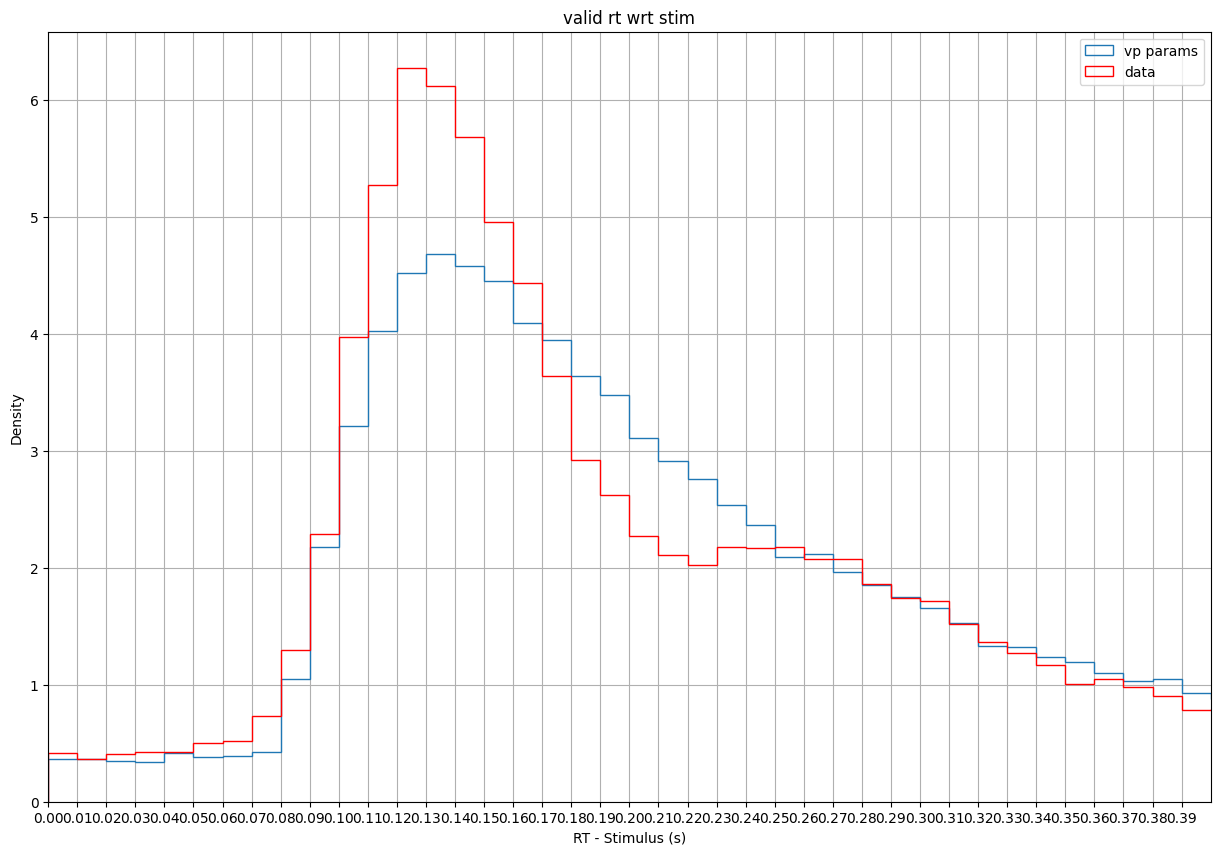

In [21]:
plt.figure(figsize=(15,10))
rt_wrt_stim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
bins = np.arange(0, 2, 0.01)
plt.hist(rt_wrt_stim, bins=bins, density=True, histtype='step', label='vp params');

data_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']
plt.hist(data_rt_wrt_stim, bins=bins, density=True, histtype='step', color='red', label='data');
plt.xlabel('RT - Stimulus (s)');    
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt stim')
# plt.xlim(-1,1)
plt.grid(True)
plt.xlim(0,0.4)
xticks = np.arange(0, 0.4, 0.01)
plt.xticks(xticks, [f'{x:.2f}' for x in xticks]);

## valid rt wrt fix

Text(0.5, 1.0, 'valid rt wrt fix')

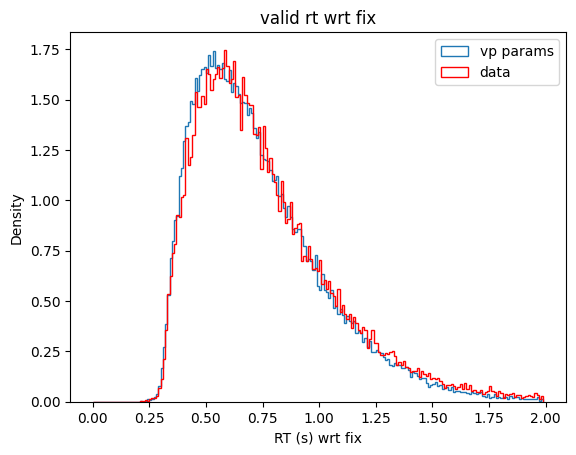

In [22]:
rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
data_rt = df_1['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(data_rt, bins=bins, density=True, histtype='step', color='red', label='data');

plt.xlabel('RT (s) wrt fix');
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt fix')


## all rt wrt fix

Text(0.5, 1.0, 'all rt inclding aborts wrt fix')

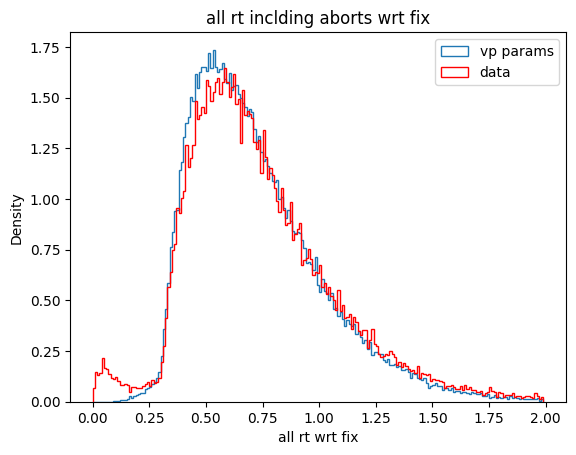

In [23]:
all_rt = [res['rt'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt inclding aborts wrt fix')

# all rt wrt fix, trunc aborts removed

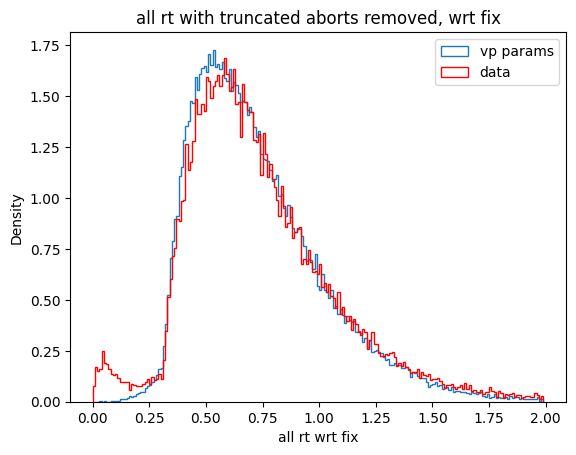

In [24]:
all_rt = [res['rt'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt fix');

## all rt wrt stim

(-1.0, 1.0)

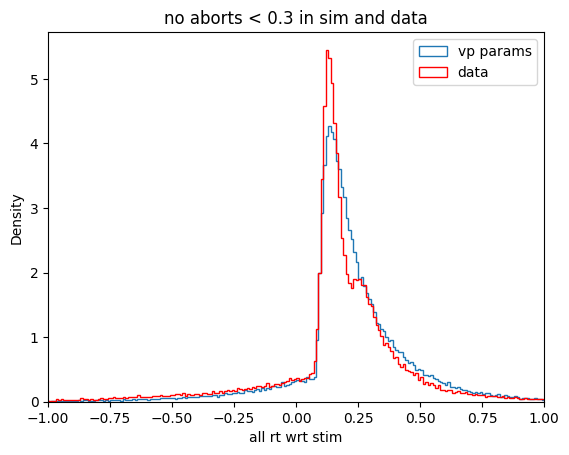

In [25]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] < 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-2, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('no aborts < 0.3 in sim and data');
plt.xlim(-1,1)

# all rt wrt stim trunc aborts removed

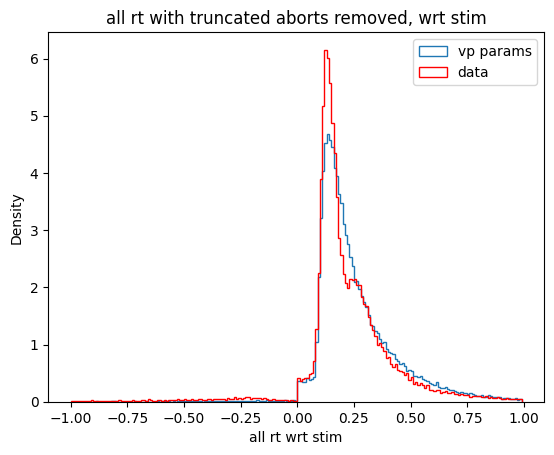

In [26]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt stim');

## psychometric

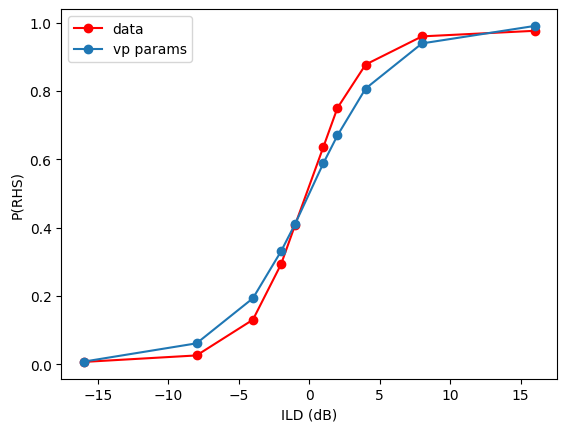

In [27]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ]
sim_results_valid_df = sim_results_valid_df.copy()

sim_results_valid_df.loc[:, 'RHS'] = (sim_results_valid_df['choice'] > 0).astype(int)
sim_grouped = sim_results_valid_df.groupby('ILD')['RHS'].mean().reset_index()

# data
data_df = df_1.copy()
data_df.loc[:, 'RHS'] = (data_df['response_poke'] == 3).astype(int)
data_grouped = data_df.groupby('ILD')['RHS'].mean().reset_index()

plt.plot(data_grouped['ILD'], data_grouped['RHS'], label='data', marker='o', color='red');
plt.plot(sim_grouped['ILD'], sim_grouped['RHS'], label='vp params', marker='o');
plt.xlabel('ILD (dB)');
plt.ylabel('P(RHS)');
plt.legend();

## tachometric

/tmp/ipykernel_3301298/464138592.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()
/tmp/ipykernel_3301298/464138592.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()


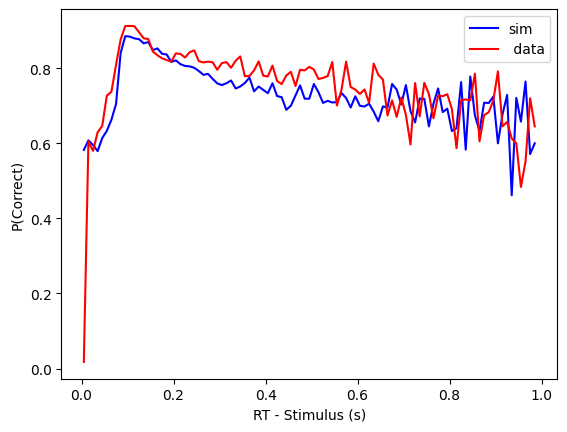

In [28]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

# sim results
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ].copy()
sim_results_valid_df.loc[:, 'correct'] = (sim_results_valid_df['choice'] * sim_results_valid_df['ILD'] > 0)
sim_results_valid_df.loc[:, 'rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

sim_results_valid_df['rt_bin'] = pd.cut(sim_results_valid_df['rt_wrt_stim'], bins=bins, right=False)
sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, sim_grouped['correct'], linestyle='-', label='sim', color='b')

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

data_df['rt_bin'] = pd.cut(data_df['rt_wrt_stim'], bins=bins, right=False)
data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, data_grouped['correct'], linestyle='-', label=' data', color='r')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('P(Correct)');
plt.legend();


# tachometric ABL wise

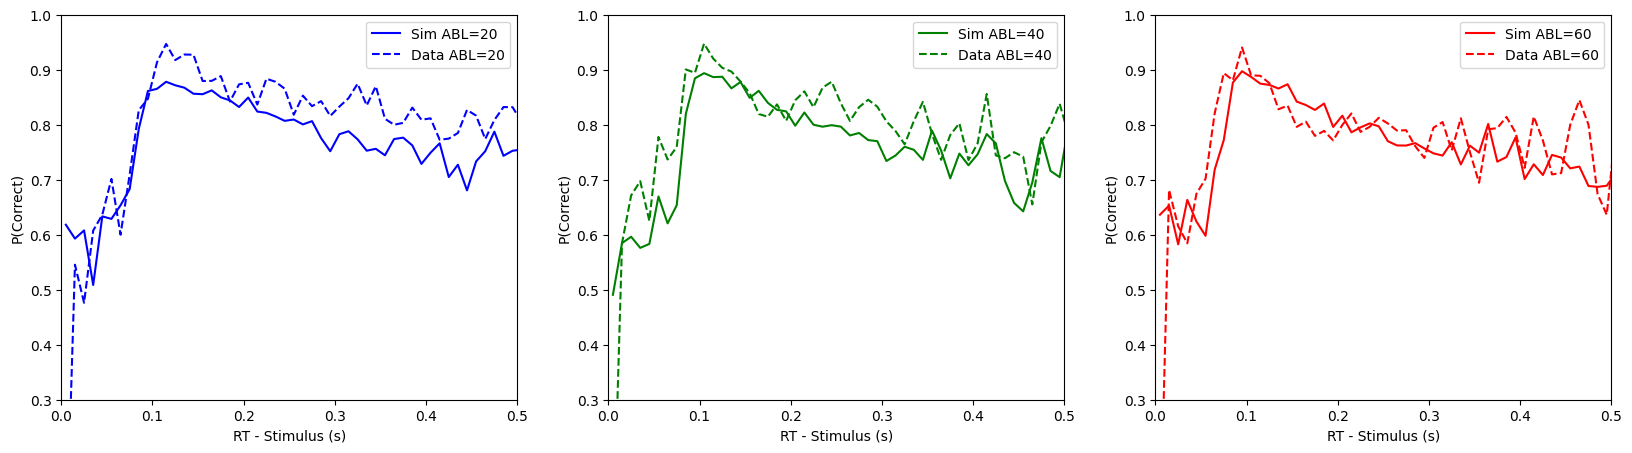

In [29]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

plt.figure(figsize=(20, 5))

ABL_values = np.sort(df_1['ABL'].unique())
colors = ['b', 'g', 'r']  # You can pick your own color scheme
a = 1
for abl_val, c in zip(ABL_values, colors):
    plt.subplot(1, len(ABL_values), a)
    # --- 1) Filter SIM dataframe for the given ABL value ---
    sim_sub = sim_results_valid_df[sim_results_valid_df['ABL'] == abl_val].copy()
    # Bin the RT values
    sim_sub['rt_bin'] = pd.cut(sim_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    sim_grouped = sim_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot SIM result (solid line)
    plt.plot(bin_centers, sim_grouped['correct'], 
            linestyle='-', 
            color=c, 
            label=f'Sim ABL={abl_val}')
    
    # --- 2) Filter DATA dataframe for the given ABL value ---
    data_sub = data_df[data_df['ABL'] == abl_val].copy()
    # Bin the RT values
    data_sub['rt_bin'] = pd.cut(data_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    data_grouped = data_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot DATA result (dashed line)
    plt.plot(bin_centers, data_grouped['correct'], 
            linestyle='--', 
            color=c, 
            label=f'Data ABL={abl_val}')

        # Cosmetics
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('P(Correct)')
    plt.ylim([0.3, 1])  # If you want to fix y-limits
    plt.xlim(0, 0.5)
    plt.legend()
    a += 1



# investigate second bump

In [ ]:
low_rt = 0.2
high_rt = 0.3

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='Data', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='All Data', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('Second Bump Data Distribution')

In [ ]:
# Assuming `trial` column in df_second_bump contains integer values
# Create a list of trials minus 1
trial_minus_1 = df_second_bump['trial'] - 1

# Filter rows from df_1 where the trial column matches the values in trial_minus_1
filtered_df = og_df[og_df['trial'].isin(trial_minus_1)]

# Display the filtered dataframe
abort_event = filtered_df['abort_event']

abort_event_counts = abort_event.value_counts()
abort_event_counts.plot(kind="bar", edgecolor="black")
plt.title(f'Abort event count of trial - 1 for second bump data btn {low_rt} and {high_rt} s')

In [34]:
# Ensure the DataFrame index is reset to align with row positions
df = df.reset_index(drop=True)

# Create a mask to identify rows where the conditions are met
mask = df.apply(
    lambda row: (
        row['trial'] > 1  # Ensure trial-1 is a valid index
        and (row['trial'] - 1) in df.index  # Check trial-1 exists in the DataFrame index
        and df.iloc[int(row['trial']) - 1]['abort_event'] == 3  # Check abort_event in trial-1
        and row['ABL'] == df.iloc[int(row['trial']) - 1]['ABL']  # Match ABL with trial-1
        and row['ILD'] == df.iloc[int(row['trial']) - 1]['ILD']  # Match ILD with trial-1
        and row['success'] == 1
    ),
    axis=1
)

# Remove the rows that meet the condition
df_removed_repeats = df[~mask]


In [35]:
df_removed_repeats_led_off_valid_trials = df_removed_repeats[ (df_removed_repeats['LED_trial'] == 0) & \
                                                             (df_removed_repeats['success'] == 1) ]

In [ ]:
rt_wrt_stim_df_non_repeat = df_removed_repeats_led_off_valid_trials['timed_fix'] \
    - df_removed_repeats_led_off_valid_trials['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(rt_wrt_stim_df_non_repeat, bins=bins, density=True, histtype='step', label='data');
plt.title('valid rt wrt stim, no repeat trials')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');



# see animal wise

In [ ]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

animals = df_1['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1

for animal in animals:
    animal_data = df_1[ df_1['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.title(f'valid rt wrt stim, Animal={animal}')
    a += 1


    

In [ ]:
except_animals = [92, 93, 98]
df_1_except = df_1[ ~df_1['animal'].isin(except_animals) ]

df_1_except_animals_rt_wrt_stim = df_1_except['timed_fix'] - df_1_except['intended_fix']
df_1_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(df_1_rt_wrt_stim, bins=bins, density=True, histtype='step', label='all', ls='--');
plt.hist(df_1_except_animals_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'removed except {except_animals}');
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.title(f'valid rt wrt stim, except {except_animals}');
plt.legend();

# df led on also?

In [ ]:
df_led_on = df [ df['LED_trial'] == 1 ]
df_led_on_valid_trials = df_led_on[ df_led_on['success'] == 1 ]
led_on_rt_wrt_stim = df_led_on_valid_trials['timed_fix'] - df_led_on_valid_trials['intended_fix']

led_off_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(led_on_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
plt.hist(led_off_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b', alpha=0.6);
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.legend();
plt.title('all animals valid rt wrt stim');

In [ ]:
# animal wise LED on

animals = df_led_on['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1
for animal in animals:
    animal_data = df_led_on_valid_trials[ df_led_on_valid_trials['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ON,  Animal={animal}')
    a += 1
    

# plot RTs as func of ABL

In [ ]:
plt.figure(figsize=(20, 5))
a = 1
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
    plt.subplot(1, len(ABL_arr), a)
    plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ABL={ABL}')
    a += 1
    


In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,30))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    for ABL in ABL_arr:
        plt.subplot(5, 3, a)

        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
        plt.xlabel('RT - Stimulus (s)');
        plt.ylabel('density')
        plt.title(f'abs ILD={ILD}')
        plt.legend();
        a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,5))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    plt.subplot(1,6, a)
    for ABL in ABL_arr:
        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ILD={ILD}')
    plt.legend();
    a += 1

In [ ]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,15))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    plt.subplot(3,1, a)
    for ILD in pos_ILD:
        ILD_data = ABL_data[ (ABL_data['ILD'] == ILD) | (ABL_data['ILD'] == -ILD) ]
        ILD_rt_wrt_stim = ILD_data['timed_fix'] - ILD_data['intended_fix']
        plt.hist(ILD_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ILD={ILD}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ABL={ABL}')
    a += 1

# all animals on and off

In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']

    plt.subplot(1, len(animals), a)
    plt.hist(animal_on_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
    plt.hist(animal_off_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1



In [ ]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']
    plt.subplot(1, len(animals), a)
    # hist on - hist off
    hist_on, _ = np.histogram(animal_on_valid_rt_wrt_stim, bins=bins, density=True)
    hist_off, _ = np.histogram(animal_off_valid_rt_wrt_stim, bins=bins, density=True)

    plt.plot(bins[:-1], hist_on - hist_off, label='LED ON - LED OFF');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1

